# Part 2 - Modelling and Evaluation

In this second notebook, we will look at multiple classification models and evaluate them using the various evaluation metrics to identify the best model that helps us distinguish between two subreddit posts.

As usual we are going to import all relevant libraries first.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score,\
                            plot_confusion_matrix, plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Modelling

Import our cleaned dataset.

In [2]:
#import data
df = pd.read_csv('./data/combined_cleaned.csv')

In [3]:
df.head()

,label,author,text_cleaned
0,0,nyc_brand,excit tool librari 2021 everyon industri probl...
1,0,iam_syndrome,python r program languag better better scope f...
2,0,Emperor-SuN-5,tool languag technolog learn beginn field anal...
3,0,_StunningStar_,tip academia positioni read post land posit bi...
4,0,shreyansh26,ml optim scratch jaxgithub link includ link ka...


### Model Training

#### Baseline Model and Train Test Split

We will then establish a baseline model using the actual values of our target variable, the 'label' feature. Our best model has to beat this baseline accuracy score and then split our data to training set and testing set. 

##### Baseline Model

In [4]:
df['label'].value_counts(normalize=True)

1    0.581042
0    0.418958
Name: label, dtype: float64

The baseline accuracy of predicting a post that belongs to r/datascience is approximately 58%. Our best model has to beat this accuracy score. 

##### Train Test Split

Initialise our X and y variable and train test split our data.

In [5]:
X = df['text_cleaned']
y = df['label']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

#### Training Machine Learning Models

In this section we are going to train multiple machine learning models using vectorizers and gridsearchCV. 

##### Vectorizers

Vectorizers are functions used to transform given texts to document-term matrixes. The purpose of this is to make documents more platable for computers to understand by converting texts to some sort of numerical features. We will be using two types, CountVectorizer and TFIDF Vectorizer.

###### Count Vectorizer

CountVectorizer is a straightforward vectorizer that counts the number of times a token shows up in the document and uses this value as a weight. We will set the paramters of the CountVectorizer as follows.

In [7]:
cvec_params = {
    'cvec__max_features': [None, 1000, 2000, 5000],
    'cvec__min_df': [1,2],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1,1), (1,2), (2,2)]}

###### TFIDF Vectorizer

TFIDFVectorizer refers to 'Term Frequency-Inverse Document Frequency' where the weight assigned to the token depends on not only its frequency in 1 document but how in all documents. We will set the paramters of the TFIDFVectorizer as follows.

In [8]:
tfidf_params = {
    'tfidf__max_features': [None, 1000, 2000, 3000, 6000],
    'tfidf__min_df': [1,2],
    'tfidf__max_df': [0.9, 0.95],
    'tfidf__ngram_range': [(1,1), (1,2),(2,2)]}

We will create a few functions to avoid repetitives of the model training processes.

In [9]:
#function to combine our vectorizers and model hyperparameters
def combine_params(vec_param, model_param):
    pipe_param = {**vec_param, **model_param}
    return pipe_param

In [10]:
#list to store results and evaluation metrics for models
model_results = []

#function to train model and store results in model_results list
def model_eval(pipeline, params):
    
    gs = GridSearchCV(estimator = pipeline,
                  param_grid = params, 
                  scoring = 'accuracy',
                  verbose = 1,
                  n_jobs = -1) 
    
   
    gs.fit(X_train, y_train)  #fit our model onto gridsearchCV
    
   
    results = {}  #initialise results dictionary
    results['Vectorizer'] = pipeline.steps[0][1]    #Vectorizer used
   
  
    #for loop to check for knn model as knn model has StandardScaler in its pipeline
    for lists in pipe.steps:
        if 'knn' in lists:
            results['Classifier'] = pipeline.steps[2][1]   #model name
        else:
            results['Classifier'] = pipeline.steps[1][1]
    
    results['Train Accuracy Score'] = gs.score(X_train, y_train) #train acctracy score
    y_pred = gs.predict(X_test)
    results['Test Accuracy Score'] = accuracy_score(y_test, y_pred) #test accuracy score
    results['Recall'] = recall_score(y_test, y_pred)  #recall score
    results['Precision'] = precision_score(y_test, y_pred)  #precision score
    results['F1-Score'] = f1_score(y_test, y_pred) #f1-score
    results['ROC-AUC'] = roc_auc_score(y_test, y_pred) #roc-auc curve
    model_results.append(results) #append dictionary into model_results list
    
    return gs.best_estimator_

###### Machine Learning Models

##### Logistic Regression 

In [11]:
#set parameters for pipeline
lr_params = {'lr__penalty': ['l1', 'l2'],
             'lr__C': [0.1, 0.3, 0.5, 0.7] }

###### Model 1: Logistic Regression - Count Vectorizer

In [12]:
#pipeline with vectoriser and classifier
pipe = Pipeline([
        ('cvec', CountVectorizer()),
        ('lr', LogisticRegression(solver = 'liblinear', max_iter = 1000, random_state = 42))
])

#combine vectoriser parameters and classifier parameters
pipe_params = combine_params(cvec_params, lr_params)

#evaluate model
model_eval(pipe, pipe_params)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  1.2min finished


Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=2000, min_df=2,
                                 ngram_range=(1, 2))),
                ('lr',
                 LogisticRegression(C=0.5, max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

###### Model 2: Logistic Regression - TFIDF Vectorizer

In [13]:
pipe = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('lr', LogisticRegression(solver = 'liblinear', max_iter = 1000, random_state=42))
])

pipe_params = combine_params(tfidf_params, lr_params)

model_eval(pipe, pipe_params)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  1.4min finished


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=1000, min_df=2,
                                 ngram_range=(1, 2))),
                ('lr',
                 LogisticRegression(C=0.7, max_iter=1000, random_state=42,
                                    solver='liblinear'))])

##### K Nearest Neighbors

In [14]:
knn_params = {'knn__p': [1,2],
              'knn__n_neighbors': [3, 5, 7],
              'knn__weights': ['uniform', 'distance']}

###### Model 3: KNN - Count Vectorizer

In [15]:
pipe = Pipeline([
        ('cvec', CountVectorizer()),
        ('ss', StandardScaler(with_mean = False)),
        ('knn', KNeighborsClassifier(n_neighbors = 5))
])

pipe_params = combine_params(cvec_params, knn_params)

model_eval(pipe, pipe_params)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  1.9min finished


Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=1000,
                                 ngram_range=(2, 2))),
                ('ss', StandardScaler(with_mean=False)),
                ('knn', KNeighborsClassifier(weights='distance'))])

###### Model 4: KNN - TFIDF Vectorizer

In [16]:
pipe = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('ss', StandardScaler(with_mean = False)),
        ('knn', KNeighborsClassifier(n_neighbors = 5))
])

pipe_params = combine_params(tfidf_params, knn_params)

model_eval(pipe, pipe_params)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  2.5min finished


Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.9, max_features=1000)),
                ('ss', StandardScaler(with_mean=False)),
                ('knn',
                 KNeighborsClassifier(n_neighbors=7, weights='distance'))])

##### Multinomial Naive Bayes

In [42]:
mnb_params = {'mnb__alpha': [0.2, 0.3, 0.5, 0.7]}

###### Model 5: Multinomial NB - Count Vectorizer

In [43]:
pipe = Pipeline([
        ('cvec', CountVectorizer()),
        ('mnb', MultinomialNB())
])

pipe_params = combine_params(cvec_params, mnb_params)
    
model_eval(pipe, pipe_params)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   35.0s finished


Pipeline(steps=[('cvec', CountVectorizer(max_df=0.9, max_features=2000)),
                ('mnb', MultinomialNB(alpha=0.5))])

###### Model 6: Multinomial NB - TFIDF Vectorizer

In [44]:
pipe = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('mnb', MultinomialNB())
])

pipe_params = combine_params(tfidf_params, mnb_params)

model_eval(pipe, pipe_params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 474 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   54.6s finished


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=2000, min_df=2)),
                ('mnb', MultinomialNB(alpha=0.2))])

##### Decision Trees

###### Model 7: Decision Tree - Count Vectorizer

In [20]:
dtree_params = {'dtree__max_depth': [None, 3, 5, 7, 9], 
                'dtree__ccp_alpha': [1, 0.1, 0.01, 0.001, 0]
}

In [21]:
pipe = Pipeline([
        ('cvec', CountVectorizer()),
        ('dtree', DecisionTreeClassifier(random_state = 42))
])

pipe_params = combine_params(cvec_params, dtree_params)

model_eval(pipe, pipe_params)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 514 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 1314 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 1864 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2514 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3264 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4114 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 5064 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:  4.4min finished


Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=5000,
                                 ngram_range=(1, 2))),
                ('dtree',
                 DecisionTreeClassifier(ccp_alpha=0.001, max_depth=9,
                                        random_state=42))])

###### Model 8: Decision Tree - TFIDF Vectorizer

In [22]:
pipe = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('dtree', DecisionTreeClassifier(random_state = 42))
])

pipe_params = combine_params(tfidf_params, dtree_params)

model_eval(pipe, pipe_params)

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:  6.3min finished


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=2000,
                                 ngram_range=(1, 2))),
                ('dtree',
                 DecisionTreeClassifier(ccp_alpha=0.01, max_depth=7,
                                        random_state=42))])

##### Random Forest

###### Model 9: Random Tree - Count Vectorizer

In [23]:
rf_params = {'rf__n_estimators': [100, 200, 300],
             'rf__max_depth': [2, 4, 6]}

In [24]:
pipe = Pipeline([
        ('cvec', CountVectorizer()),
        ('rf', RandomForestClassifier(random_state = 42, n_jobs=-1))
])

pipe_params = combine_params(cvec_params, rf_params)

model_eval(pipe, pipe_params)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  4.6min finished


Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=1000, min_df=2,
                                 ngram_range=(1, 2))),
                ('rf',
                 RandomForestClassifier(max_depth=6, n_estimators=200,
                                        n_jobs=-1, random_state=42))])

###### Model 10: Random Tree - TFIDF Vectorizer

In [25]:
pipe = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('rf', RandomForestClassifier(random_state = 42, n_jobs=-1))
])

pipe_params = combine_params(tfidf_params, rf_params)

model_eval(pipe, pipe_params)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:  5.6min finished


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=1000, min_df=2)),
                ('rf',
                 RandomForestClassifier(max_depth=6, n_jobs=-1,
                                        random_state=42))])

##### Support Vector Classifier

###### Model 11: SVC - Count Vectorizer

In [26]:
svc_params = {'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'svc__C': [0.01, 0.1, 1, 5, 10]}

In [27]:
pipe = Pipeline([
        ('cvec', CountVectorizer()),
        ('svc', SVC(random_state = 42))
])

pipe_params = combine_params(cvec_params, svc_params)

model_eval(pipe, pipe_params)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  5.2min finished


Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=2000, min_df=2,
                                 ngram_range=(1, 2))),
                ('svc', SVC(C=5, random_state=42))])

###### Model 12: SVC - TFIDF Vectorizer

In [28]:
pipe = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('svc', SVC(random_state = 42))
])

pipe_params = combine_params(tfidf_params, svc_params)

model_eval(pipe, pipe_params)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:  6.1min finished


Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.9, ngram_range=(1, 2))),
                ('svc', SVC(C=1, kernel='sigmoid', random_state=42))])

#### Model Performance and Evaluation

##### Model Performance Overview

Let us convert our model_results list into a dataframe for better visualisation.

In [45]:
model_performance = pd.DataFrame(model_results).sort_values(by= 'Test Accuracy Score', ascending = False)

In [47]:
model_performance.reset_index(drop=True)

,Vectorizer,Classifier,Train Accuracy Score,Test Accuracy Score,Recall,Precision,F1-Score,ROC-AUC
0,TfidfVectorizer(),MultinomialNB(),0.950362,0.824096,0.921162,0.804348,0.858801,0.805408
1,CountVectorizer(),MultinomialNB(),0.914168,0.821687,0.871369,0.830040,0.850202,0.812121
2,TfidfVectorizer(),SVC(random_state=42),0.986556,0.819277,0.883817,0.819231,0.850299,0.806851
3,CountVectorizer(),"LogisticRegression(max_iter=1000, random_state...",0.931748,0.804819,0.908714,0.787770,0.843931,0.784817
4,TfidfVectorizer(),"LogisticRegression(max_iter=1000, random_state...",0.893485,0.804819,0.950207,0.768456,0.849722,0.776828
5,TfidfVectorizer(),DecisionTreeClassifier(random_state=42),0.796277,0.771084,0.941909,0.737013,0.826958,0.738196
6,CountVectorizer(),DecisionTreeClassifier(random_state=42),0.844881,0.751807,0.933610,0.721154,0.813743,0.716805
7,CountVectorizer(),"RandomForestClassifier(n_jobs=-1, random_state...",0.802482,0.746988,0.995851,0.697674,0.820513,0.699075
8,TfidfVectorizer(),"RandomForestClassifier(n_jobs=-1, random_state...",0.804550,0.734940,0.983402,0.690962,0.811644,0.687104
9,CountVectorizer(),KNeighborsClassifier(),0.953464,0.607229,0.817427,0.623418,0.707361,0.566760


Model Observations

Overall, all of the models have performed well and beat the baseline score. 

1. There are at least 5 models with test accuracy score of more than 80%. These 5 models also have comparable roc-auc scores with test accuracy scores.
2. On average, both the Multinomial Naive Bayes models and Logistic Regression models performed the best despite SVM model achieving the highest test accuracy scores.
3. Both K Nearest Neighbors models have very low test accuracy scores and are the worst performing models. However, they also have really high, if not the best train accuracy scores, showing signs of overfitting despite hyperparamter tuning. 
4. On average, TFDIF Vectorizer performs better than Count Vectorizer

###### Top 2 Models

Let us compare our top 2 models and dwell into their evaluation metrics to see which model has performed the best.

In [48]:
model_performance.iloc[[0,2]].reset_index(drop= True)

,Vectorizer,Classifier,Train Accuracy Score,Test Accuracy Score,Recall,Precision,F1-Score,ROC-AUC
0,TfidfVectorizer(),MultinomialNB(),0.950362,0.824096,0.921162,0.804348,0.858801,0.805408
1,TfidfVectorizer(),SVC(random_state=42),0.986556,0.819277,0.883817,0.819231,0.850299,0.806851


As seen above, the SVM model has an edge over the Mulitnomial NB model on the train accuracy score, however differs only by approximately 0.5% for the test accuracy scores. The test accuracy scores perform well against the roc-auc scores as well.

##### Evaluation Metrics

###### Confusion Matrix

Let us look at the confusion matrix for both models based on their best estimators. 

The best vectorizer appears to TFIDF vectorizer. So we will instantiate that first.

In [49]:
vec = TfidfVectorizer(max_df=0.9)

In [50]:
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

*Best SVM Model*

In [51]:
#instantiate model and fit x_train, y_train
svc = SVC(kernel = 'sigmoid', C=1)
svc.fit(X_train_vec, y_train)

SVC(C=1, kernel='sigmoid')

*Best Multinomial NB Model*

In [85]:
#instantiate model and fit x_train, y_train
mnb = MultinomialNB(alpha = 0.2)
mnb.fit(X_train_vec, y_train)

MultinomialNB(alpha=0.2)

*Plotting confusion matrix*

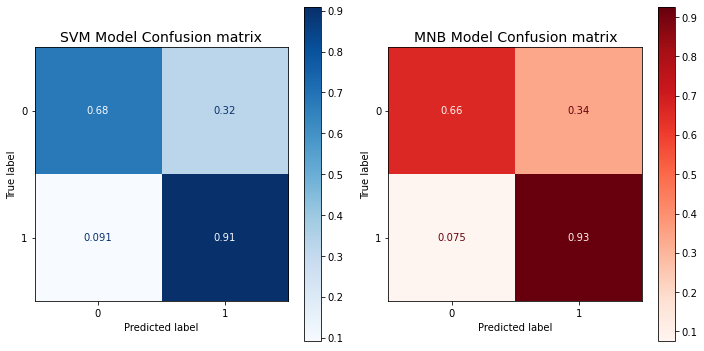

In [53]:
fig, ax = plt.subplots(1, 2, figsize= (10,5)) #for both subreddits
ax = ax.ravel()
    
#SVC Model confusion matrix 
plot_confusion_matrix(svc, X_test_vec, y_test, normalize = 'true', ax = ax[0], cmap=plt.cm.Blues)
ax[0].set_title('SVC Model Confusion matrix', fontsize=14)
    
#Multinomial NB Model confusion matrix 
plot_confusion_matrix(mnb, X_test_vec, y_test, normalize = 'true', ax = ax[1], cmap=plt.cm.Reds)
ax[1].set_title('MNB Model Confusion matrix', fontsize=14)
    
fig.tight_layout()

To recall,   
  - 0 for datascience
  - 1 for SoftwareEngineering


From the confusion matrix, it appears that both models seem to have comparable results. The Multinomial model is slightly better at predicting r/SoftwareEngineering as compared to the SVC model.

***ROC Curve***

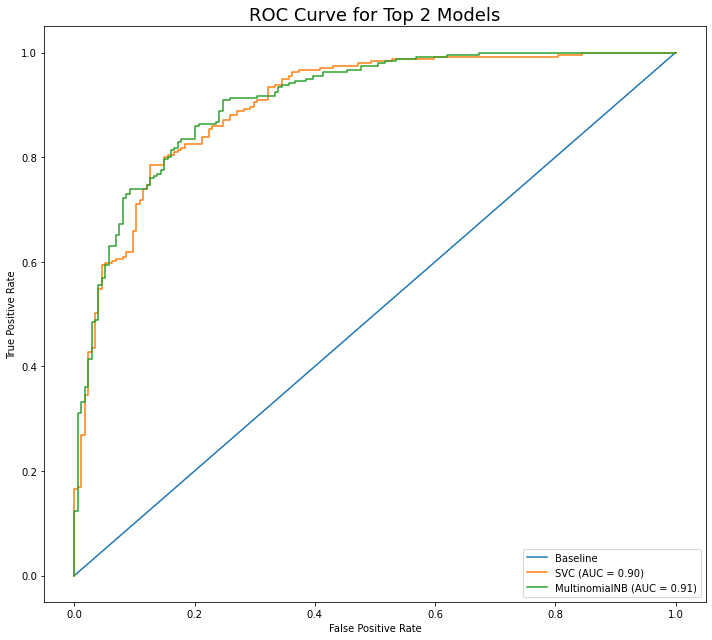

In [54]:
fig, ax = plt.subplots(1, 1, figsize= (10,9))

#baseline plot
plt.plot(np.linspace(0,1,200), np.linspace(0,1,200), label ='Baseline')

#svc roc curve
plot_roc_curve(svc, X_test_vec, y_test, ax=ax)

#mnb roc curve
plot_roc_curve(mnb, X_test_vec, y_test, ax=ax)

plt.title('ROC Curve for Top 2 Models', fontsize = 18)
plt.tight_layout()

From the ROC Curve, it is evident that Multinomial model is a better model even though both have high and comparable AUC scores.

***Feature Importance***

Besides observing the predictive features of the models, we can also take a look at how these models evaluate their features.

*Multinomial NB*

Let us take a look at the multinomial NB's feature importance and compare it with our top 20 words identified in the first notebook.

In [78]:
# Extracting top 15 important features for each subreddit
ds_prob = mnb.feature_log_prob_[0, :].argsort()[::-1]
se_prob = mnb.feature_log_prob_[1, :].argsort()[::-1] 
ds_prob = ds_prob[:20]
se_prob = se_prob[:20]

In [79]:
ds_list = np.take(vec.get_feature_names(), ds_prob)
se_list = np.take(vec.get_feature_names(), se_prob)

In [80]:
ds_feature = pd.DataFrame(data = ds_list)
se_feature = pd.DataFrame(data = se_list)

ds_feature['log probability'] = ds_prob
se_feature['log probability'] = ds_prob

ds_feature.columns = ['words','log probability' ]
se_feature.columns = ['words','log probability' ]

ds_feature.sort_values(by = 'log probability', ascending = False, inplace = True)
se_feature.sort_values(by = 'log probability', ascending = False, inplace = True)

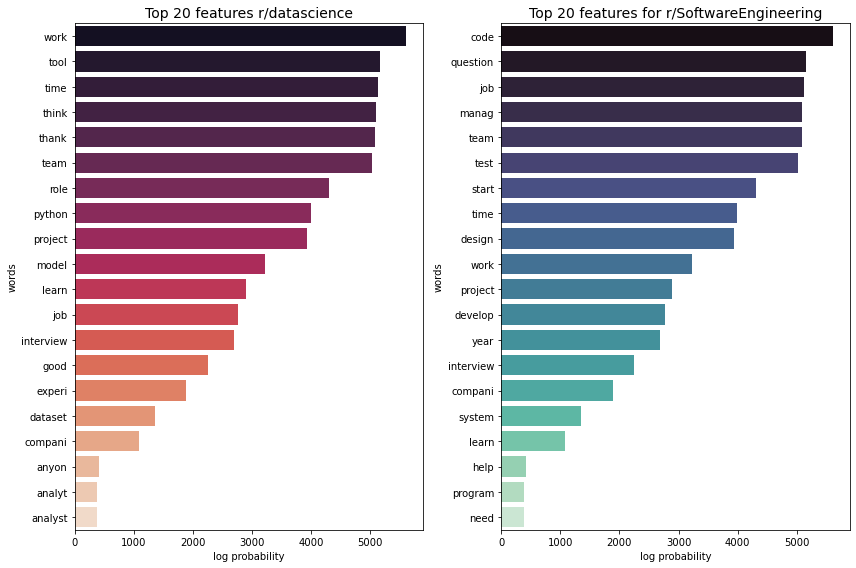

In [82]:
fig, ax = plt.subplots(1, 2, figsize= (12,8)) #for both subreddits
ax = ax.ravel()
    
#datascience barplot
sns.barplot(data = ds_feature,
                x ='log probability',
                y ='words',
                ax = ax[0],
                palette="rocket")
ax[0].set_title(f'Top 20 features r/datascience', fontsize=14)
    
 #softwareengineering barplot
sns.barplot(data = se_feature,
                x ='log probability',
                y ='words',
                ax = ax[1],
                palette="mako")
ax[1].set_title(f'Top 20 features for r/SoftwareEngineering', fontsize=14)
    
fig.tight_layout()

With comparison with our top 20 n-grams identified in part 1, there seems to be similarity between the top 20 words, showing high predicitability characteristics.

*SVM*

To determine best features for a Support Vector Classifier, we are able to do so with the coeficient values of the features. However, this works best with the linear kernel whereas our best model makes use of the sigmoid kernel. It is not possible to determine best features as the resulting separating plane exists in another place.

Therefore, our best model is the Multinomial Naive Bayes - TFIDF Vectorizer based on all of our evaluation metrics.

##### Misclassification Analysis

Let us look at misclassfied posts by our best model.

In [91]:
predict = pd.DataFrame(mnb.predict(X_test_vec), columns =[ 'predictions'])
predict = predict.join(y_test.reset_index())
predictproba = pd.DataFrame(mnb.predict_proba(X_test_vec), columns = ['ds_prob', 'se_prob'])
predict.join(predictproba)

,predictions,index,label,ds_prob,se_prob
0,0,241,0,0.546746,0.453254
1,1,1340,1,0.290303,0.709697
2,1,409,0,0.433161,0.566839
3,1,1363,1,0.121688,0.878312
4,0,656,1,0.650264,0.349736
...,...,...,...,...,...
410,0,548,0,0.826764,0.173236
411,1,636,1,0.274231,0.725769
412,0,267,0,0.716961,0.283039
413,0,315,0,0.600401,0.399599


In [93]:
predict[predict['predictions'] != predict['label']]

,predictions,index,label
2,1,409,0
4,0,656,1
14,1,27,0
16,1,260,0
22,0,1296,1
...,...,...,...
397,1,509,0
404,1,417,0
405,1,87,0
409,1,283,0


From our analysis, we can see that our best model has misclassified 77 rows, which is almost 19% of the data, which is not favourable if we were to deploy our model on unseen data.

#### Conclusion and  Limitations

In summary, we have made effective use of Natural Language Processing to distinguish posts between subreddits through multiple machine learning models. From our model performance and evaluation using classification evaluation metrics, we have identified Multinomial Naive Bayes implemented with the TFIDF Vectorizer to be the best model.

However, this was build upon certain limitations. As we were required to use Reddit's API for this project, we are restricted to retrieving 25 posts each time and hence 1000 posts a day. This hinders the amount of data we can collect and hence implement on our models. This is why we see multiple models showing signs of overfitting with higher training scores then testing scores. This can be combated with a larger amount of data compared to what we have presently.

Additionally, there were a limited number of models used for our investigation. This investigation can be enhanced by tapping into other Vectorizers such as Hashing Vectorizer as well as other hyperparameter optimisation techniques such as RandomisedCV. We can also look at boosting and bagging models to enhance our model performance further.

Another way to approach this problem is looking into sentiment analysis and seeing if we can classify our posts better using postive and negative posts.

###### Recommendations

This research can be beneficial to stakeholders who are interested in the 'data science' and 'software engineering' themes to look at what users are interested in these days and the type of content they engage in or reach out for in these subreddits. Feature importance, as identified earlier, can aid these stakeholders in understanding the kind of content users engage in the respective subreddits.

This is the end of the second notebook.